In [ ]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
from torchvision.utils import make_grid
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as tt
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import pandas as pd
import torch.optim as optim

In [ ]:
# Set the device to use the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Move the weights of the model to the GPU
for param in model.parameters():
    param.to(device)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = resize(I, (32,32),anti_aliasing=True)
        I = I.reshape(1,I.shape[0],I.shape[1])
        #transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label

In [ ]:
def get_dataloader():
    df_train=pd.read_csv('train.csv')
    df_val=pd.read_csv('val.csv')
    df_test=pd.read_csv('test.csv')

    path='S224//'

    dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values)
    dataset_val = MyDataset(path, df_val['filename'].values, df_val['label'].values)
    dataset_test = MyDataset(path, df_test['filename'].values, df_test['label'].values)

    loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    loader_val = torch_dataloader(dataset_val, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    
    return loader_train,loader_val,loader_test

In [ ]:
train,val,test  = get_dataloader()

<ipython-input-163-c7cd62d5eb71>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


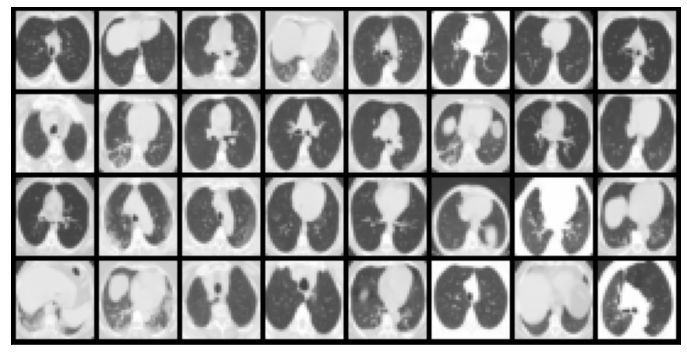

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
show_batch(train)

# Basic from Scratch CNN

In [ ]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class CovidClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)
model = CovidClassification()

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
history = fit(num_epochs, lr, model, train, val, opt_func)

<ipython-input-163-c7cd62d5eb71>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Epoch [0], train_loss: 0.6921, val_loss: 0.6876, val_acc: 0.5826
Epoch [1], train_loss: 0.6183, val_loss: 0.6223, val_acc: 0.6652
Epoch [2], train_loss: 0.5494, val_loss: 0.6352, val_acc: 0.6607
Epoch [3], train_loss: 0.4937, val_loss: 0.5379, val_acc: 0.7835
Epoch [4], train_loss: 0.4731, val_loss: 0.7506, val_acc: 0.6317
Epoch [5], train_loss: 0.4024, val_loss: 0.4350, val_acc: 0.8460
Epoch [6], train_loss: 0.3376, val_loss: 0.3968, val_acc: 0.8839
Epoch [7], train_loss: 0.3237, val_loss: 0.4053, val_acc: 0.8839
Epoch [8], train_loss: 0.3034, val_loss: 0.4262, val_acc: 0.8817
Epoch [9], train_loss: 0.2730, val_loss: 0.3835, val_acc: 0.8951
Epoch [10], train_loss: 0.2792, val_loss: 0.3672, val_acc: 0.8482
Epoch [11], train_loss: 0.2065, val_loss: 0.4120, val_acc: 0.8527
Epoch [12], train_loss: 0.1852, val_loss: 0.3646, val_acc: 0.9174
Epoch [13], train_loss: 0.1713, val_loss: 0.3695, val_acc: 0.8661
Epoch [14], train_loss: 0.1512, val_loss: 0.3947, val_acc: 0.8862
Epoch [15], train_lo

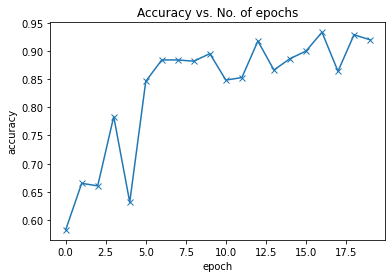

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [ ]:
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

<ipython-input-163-c7cd62d5eb71>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Test Accuracy of the model: 94.5 %


In [ ]:
outputs.shape

torch.Size([16, 2])

# Transfer Learning

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
class Resnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)

        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def forward(self, xb):
      return self.network(xb)
    
#     def freeze(self):
#         # To freeze the residual layers
#         for param in self.network.parameters():
#             param.require_grad = False
#         for param in self.network.fc.parameters():
#             param.require_grad = True
    
#     def unfreeze(self):
#         # Unfreeze all layers
#         for param in self.network.parameters():
#             param.require_grad = True
model_res = Resnet18()

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []
history += fit_one_cycle(epochs, max_lr, model_res, train, test, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

<ipython-input-163-c7cd62d5eb71>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Epoch [0], last_lr: 0.00003, train_loss: 0.6749, val_loss: 0.6458, val_acc: 0.6587
Epoch [1], last_lr: 0.00008, train_loss: 0.4294, val_loss: 0.3590, val_acc: 0.8510
Epoch [2], last_lr: 0.00010, train_loss: 0.2659, val_loss: 0.2480, val_acc: 0.8942
Epoch [3], last_lr: 0.00010, train_loss: 0.1725, val_loss: 0.1761, val_acc: 0.9447
Epoch [4], last_lr: 0.00008, train_loss: 0.1167, val_loss: 0.1449, val_acc: 0.9543
Epoch [5], last_lr: 0.00006, train_loss: 0.1131, val_loss: 0.1313, val_acc: 0.9567
Epoch [6], last_lr: 0.00004, train_loss: 0.0592, val_loss: 0.1198, val_acc: 0.9615
Epoch [7], last_lr: 0.00002, train_loss: 0.0408, val_loss: 0.1461, val_acc: 0.9567
Epoch [8], last_lr: 0.00000, train_loss: 0.0480, val_loss: 0.1392, val_acc: 0.9615
Epoch [9], last_lr: 0.00000, train_loss: 0.0242, val_loss: 0.1420, val_acc: 0.9591


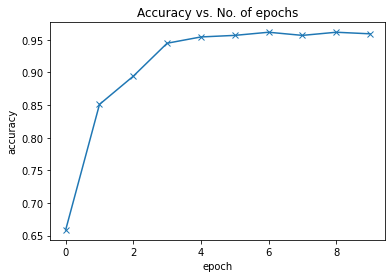

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

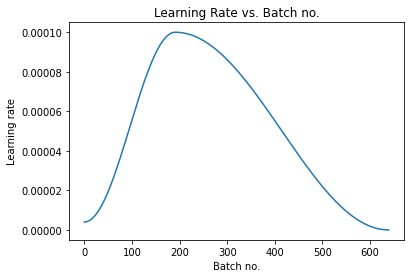

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [ ]:
model_res.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        outputs = model_res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

<ipython-input-163-c7cd62d5eb71>:17: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Test Accuracy of the model: 96.0 %


### Resnet18 is giving better accuracy than the predefined model.